## Strategies Based on Simple Moving Averages (SMA)

*[Coding along with Python for Algorithmic Trading, Yves Hilpisch, O'Reilly, 1st edition November 2020, ISBN-13: 978-1492053354]*

__Moving averages__ according to *Claude.ai*:

> A moving average is a technical analysis tool that smooths out price data by creating a constantly updated average price over a specific time period, helping traders identify trends and potential support/resistance levels while filtering out short-term market noise.

Explaining the term term __"technical analysis"__, from a [paper on simple moving averages](https://finance.martinsewell.com/stylized-facts/distribution/BrockLakonishokLeBaron1992.pdf) by Brock at al. (1992):

> The term "technical analysis" is a general heading for a myriad of trading techniques. Technical analysts attempt to forecast prices by the study of past prices and a few other related summary statistics about security trading. They belief that shifts in supply and demand can be detected in charts of market action. Technical analysis is considered by many to be the original form of investment analysis, dating back to 1800s. It came into widespread use before the period of extensive and fully disclosed financial information, which in turn enabled the practice of fundamental analysis to develop.

More from this paper about technical rules:

> In this paper, we explore two of the simplest and most popular technical rules: moving average-oscillator and trading-range break (resistance and support levels). In the first method, buy and sell signals are generated by two moving averages, a long period and a short period. [...] Our study reveals that technical analysis reveals that technical analysis helps to predict stock changes.

### Basics of backtesting trading strategies that make use of two SMAs

In [25]:
# let's get pandas
import pandas as pd
# and what we need from matplotlib
from pylab import mpl, plt

Data used in the following example: end-of-day (EOD) closing data for EUR/USD exchange rate. 

"The data in the data set is from the Refinitiv Eikon Data API and represents EOD values for the respective instruments (RICs)."

In [14]:
# for starters, let's read the data
raw = pd.read_csv("../../assets/data/aiif_eikon_eod_data.csv", index_col=0, parse_dates=True).dropna() # (1)

In [15]:
raw

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.0000,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.6500,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.5000,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.9000,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.1000,49.84,111.37
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,284.270000,157.380,59.41,1789.21,229.91,321.23,3223.38,12.67,1.1087,1498.8100,28.66,141.27
2019-12-26,289.910000,158.670,59.82,1868.77,231.21,322.94,3239.91,12.65,1.1096,1511.2979,29.08,142.38
2019-12-27,289.800000,158.960,60.08,1869.80,230.66,322.86,3240.02,13.43,1.1175,1510.4167,28.87,142.33


In [16]:
raw.info() # (2) show meta info of DatafFrame object

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [17]:
data = pd.DataFrame(raw['EUR=']) # (3) transforming Series object to DataFrame object
data

,EUR=
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412
...,...
2019-12-24,1.1087
2019-12-26,1.1096
2019-12-27,1.1175


In [18]:
data.rename(columns={'EUR=': 'price'}, inplace=True) # (4) rename column
data

,price
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412
...,...
2019-12-24,1.1087
2019-12-26,1.1096
2019-12-27,1.1175


In [19]:
data.info() # (5) meta information for new DataFrame object

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


__Calculation of SMAs by the `rolling()` method in combination with a deferred calculation operation:__

Asking *Claude.ai*, what is a __deferred calculation operation__?

> A deferred calculation operation (also called lazy evaluation) is when a computation's execution is delayed until its result is actually needed, rather than being performed immediately when the expression is defined. This approach can improve performance by avoiding unnecessary calculations and helps manage memory more efficiently, especially when dealing with large datasets or complex operations that may not always need to be fully executed.

In [20]:
# creating a column with 42 days of SMA values
# the first 41 values will be NaN
data['SMA1'] = data['price'].rolling(42).mean()

In [21]:
# creating a column with 252 days of SMA values
# the first 251 values will be NaN
data['SMA2'] = data['price'].rolling(252).mean()

In [22]:
data.tail() # printing the final five rows

,price,SMA1,SMA2
Date,,,
2019-12-24,1.1087,1.107698,1.119630
2019-12-26,1.1096,1.107740,1.119529
2019-12-27,1.1175,1.107924,1.119428
2019-12-30,1.1197,1.108131,1.119333
2019-12-31,1.1210,1.108279,1.119231


__Visualizing the original time series data in combination with the SMAs:__

In [27]:
%matplotlib inline
# plt.style.use('seaborn') # deprecated, 
# see https://stackoverflow.com/questions/74716259/the-seaborn-styles-shipped-by-matplotlib-are-deprecated-since-3-6
plt.style.use("seaborn-v0_8")
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

<Axes: title={'center': 'EUR/USD | 42 & 252 days SMAs'}, xlabel='Date'>

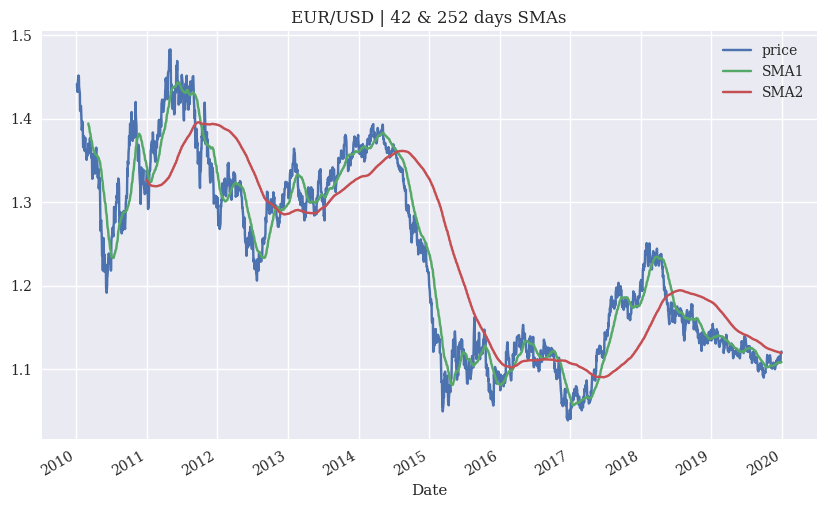

In [28]:
data.plot(
    title='EUR/USD | 42 & 252 days SMAs',
    figsize=(10,6)
)

#### __Generating Signals aka Market Positionings__

In [ ]:
Market positionings are generated based on the *relationship between the two SMAs* according to the following rule:

1. 